In [18]:
import pandas as pd
import zipfile
from io import BytesIO
import requests
#Extraendo el conjunto de datos
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00577/codon_usage.csv.zip'
r = requests.get(url)
buf1 = BytesIO(r.content)
with zipfile.ZipFile(buf1, "r") as f:
    for name in f.namelist():
        if name.endswith('.csv'):
            with f.open(name) as zd:
              #Asignando los datos de DNA Codones a la variabel df
                df = pd.read_csv(zd, encoding='latin1', sep=',')            
            break

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [19]:
#verificar los datos de condones
df.head()

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.0218,0.01357,0.01543,0.00782,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131


In [20]:
#Ver la cantidad de registrar por cada clase de Kingdom
df['Kingdom'].value_counts()

bct    2920
vrl    2832
pln    2523
vrt    2077
inv    1345
mam     572
phg     220
rod     215
pri     180
arc     126
plm      18
Name: Kingdom, dtype: int64

In [21]:
#Ver la cantidad de registros por cada clase DNA type
df['DNAtype'].value_counts()

0     9267
1     2899
2      816
4       31
12       5
3        2
9        2
5        2
11       2
6        1
7        1
Name: DNAtype, dtype: int64

In [22]:
#importando librerias para utilizar graficos con matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


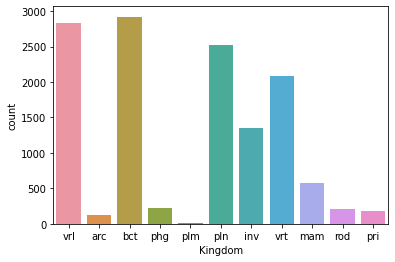

In [23]:
#graficar las cantidad por clase de kingdom
sns.countplot(df['Kingdom'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


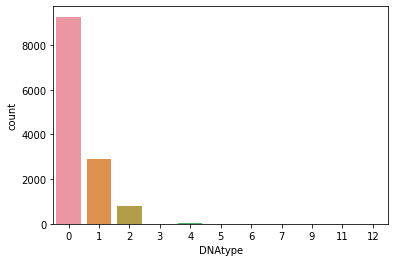

In [24]:
#graficar las cantidad por clase de DNA type
sns.countplot(df['DNAtype'])

In [25]:
import numpy as np

#remplazar valores 'non-B hepatitis virus','12;I', '-' con NAN 
df['UUU'] = df['UUU'].replace(['non-B hepatitis virus','12;I'], np.nan)
df['UUC'] = df['UUC'].replace('-', np.nan)

#convertir las columnas a tipo float32 porque inicialmente se encontraban tipo objeto
df['UUU'] = df['UUU'].astype('float32')
df['UUC'] = df['UUC'].astype('float32')

In [26]:
#eliminar registros que tienen valores NAN (para este caso sólo eliminará dos registros)
df.dropna(inplace=True)

In [27]:
#Copia de dataset para modelos de clasificación con DNA y Kingdom
#la copia se realizá para cada clase porque se desarrollarán modelos de forma independientes "DNA" y "Kingdom"
df_dna = df.copy()
df_kingdom = df.copy()

### Modelo para la clasificación de tipo de DNA

In [28]:
#contar las cantidades por cada clase
count_dnatype = df_dna['DNAtype'].value_counts()

# convirtiendo a tipo dataframa las clases DNAType & cantidad
df_counts_dna = pd.DataFrame(count_dnatype)
df_counts_reset_dna = df_counts_dna.reset_index()
df_counts_reset_dna.columns = ['DNAType_unique', 'counts'] # change column names

#luego de convertir debemos eliminar las clases que tienen menores o iguales a 31 registros,
# porque son muy pocos para que se puedan entrenar en el modelo
for i in range(len(df_counts_reset_dna)):
  if df_counts_reset_dna['counts'][i] <= 31:
    df_dna.drop(df_dna[df_dna['DNAtype']==df_counts_reset_dna['DNAType_unique'][i]].index, axis=0, inplace=True)    

In [29]:
#verificando las clases que serán entrenadas
df_dna['DNAtype'].value_counts()

0    9265
1    2899
2     816
Name: DNAtype, dtype: int64

In [30]:
#seperando las dimensiones en "X" y "Y"
# eliminamos 'Kingdom', 'SpeciesName', 'SpeciesID' porque tienen variables únicas

X_dna = df_dna.drop(columns = ['DNAtype', 'Kingdom', 'SpeciesName', 'SpeciesID'], axis = 1)
y_dna = df_dna['DNAtype']

In [31]:
#mostrando las dimensiones de X y Y
print("Dimensión X ", X_dna.shape)
print("Dimensión y ", y_dna.shape)

Dimensión X  (12980, 65)
Dimensión y  (12980,)


In [32]:
#Separando datos para entrenamiento y test en el modelo de DNA types
from sklearn.model_selection import train_test_split
X_train_dna, X_test_dna, y_train_dna, y_test_dna = train_test_split(X_dna, y_dna, test_size = 0.2, random_state = 0)

In [33]:
# creando la grilla o tabla de hyperparametros que serán evaluados
from pprint import pprint
rf_grid_dna = {'max_depth':[3,5,10,None],
          'n_estimators':[10,100,200,300,400,500],
          'max_features':['auto', 'sqrt'],
          'criterion':['gini','entropy'],
          'bootstrap':[True,False],
          'min_samples_leaf':[1, 2, 4],
          'min_samples_split': [2, 4, 5, 10]
  }
print('Los valores a probar en la búsqueda por grilla son:')
pprint(rf_grid_dna)

Los valores a probar en la búsqueda por grilla son:
{'bootstrap': [True, False],
 'criterion': ['gini', 'entropy'],
 'max_depth': [3, 5, 10, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 4, 5, 10],
 'n_estimators': [10, 100, 200, 300, 400, 500]}


In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

model_grid_rfc_dna = RandomForestClassifier()
rf_grid_search_dna = RandomizedSearchCV(
    estimator=model_grid_rfc_dna,
    param_distributions=rf_grid_dna,
    n_jobs=-1,    
    cv=3
)
rf_grid_search_dna.fit(X_train_dna, y_train_dna)

rf_gridsearch_best = rf_grid_search_dna.best_estimator_

print('Los hiperparámetros del mejor modelo son:')
pprint(rf_grid_search_dna.best_params_)
print()

#mostrando resultados de test y validación del modelo con Random Forest
print('Exactitud luego de búsqueda en grilla en entrenamiento DNA:', rf_gridsearch_best.score(X_train_dna, y_train_dna))
print('Exactitud luego de búsqueda en grilla en validación DNA:', rf_gridsearch_best.score(X_test_dna, y_test_dna))

Los hiperparámetros del mejor modelo son:
{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 200}

Exactitud luego de búsqueda en grilla en entrenamiento DNA: 1.0
Exactitud luego de búsqueda en grilla en validación DNA: 0.9938366718027735


In [38]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

y_predict_test_dna = rf_grid_search_dna.predict(X_test_dna)

print('AUC :', roc_auc_score(y_test_dna, rf_grid_search_dna.predict_proba(X_test_dna),multi_class='ovo'))
print("--- Report ---")
print(classification_report(y_test_dna, y_predict_test_dna))

AUC : 0.9995037722215582
--- Report ---
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1835
           1       1.00      0.99      1.00       589
           2       0.99      0.94      0.96       172

    accuracy                           0.99      2596
   macro avg       0.99      0.98      0.99      2596
weighted avg       0.99      0.99      0.99      2596



In [39]:
# Aplicando SmoteTomek para el balanceo de datos en las tres clases utilizadas
from imblearn.combine import SMOTETomek
smt_dna = SMOTETomek()
#generando balanceo de datos
X_train_dna_smt, y_train_dna_smt = smt_dna.fit_resample(X_train_dna, y_train_dna)
print(f'''Cambio de X train dna antes de SMOTE: {X_train_dna.shape} 
Cambio de X train dna después de SMOTE: {X_train_dna_smt.shape}''')

#verificando las nuevas cantidades de balancceo de datos
print('\n Balance de class DNA :')
y_train_dna_smt.value_counts()

Cambio de X train dna antes de SMOTE: (10384, 65) 
Cambio de X train dna después de SMOTE: (19408, 65)

 Balance de class DNA :


2    6679
1    6452
0    6277
Name: DNAtype, dtype: int64

In [40]:
# Ahora pasamos aplicar redución de dimensionalidad con PCA
from sklearn.decomposition import PCA

#numero de componentes para dimensionalidad es 3
pca_dna = PCA(n_components=3)
X_train_smt_dna_pca = pca_dna.fit_transform(X_train_dna_smt)
X_test_dna_pca = pca_dna.transform(X_test_dna)
pca_dna.explained_variance_ratio_

array([1.00000000e+00, 1.24074567e-14, 8.28066724e-15])

In [41]:
# creamos el modelos RF con las nuevas dimensiones y utilizando los mejores hyperparametros

model_grid_rfc_dna_pca = RandomForestClassifier()
rf_grid_search_dna_pca = RandomizedSearchCV(
    estimator=model_grid_rfc_dna_pca,
    param_distributions=rf_grid_dna,
    n_jobs=-1,    
    cv=3
)
rf_grid_search_dna_pca.fit(X_train_smt_dna_pca, y_train_dna_smt)

rf_gridsearch_best_pca = rf_grid_search_dna_pca.best_estimator_

print('Los hiperparámetros del mejor modelo son:')
pprint(rf_grid_search_dna_pca.best_params_)
print()

print('Exactitud luego de búsqueda en grilla en entrenamiento DNA:', rf_gridsearch_best_pca.score(X_train_smt_dna_pca, y_train_dna_smt))
print('Exactitud luego de búsqueda en grilla en validación DNA:', rf_gridsearch_best_pca.score(X_test_dna_pca, y_test_dna))

Los hiperparámetros del mejor modelo son:
{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

Exactitud luego de búsqueda en grilla en entrenamiento DNA: 1.0
Exactitud luego de búsqueda en grilla en validación DNA: 0.947226502311248


In [42]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

y_predict_test_dna_pca = rf_grid_search_dna_pca.predict(X_test_dna_pca)

print('AUC :', roc_auc_score(y_test_dna, rf_grid_search_dna_pca.predict_proba(X_test_dna_pca),multi_class='ovo'))
print("--- Report ---")
print(classification_report(y_test_dna, y_predict_test_dna_pca))

AUC : 0.9914133080272793
--- Report ---
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1835
           1       0.96      0.96      0.96       589
           2       0.65      0.87      0.74       172

    accuracy                           0.95      2596
   macro avg       0.86      0.93      0.89      2596
weighted avg       0.95      0.95      0.95      2596



### Modelo para clasificación de clases en "Kingdom"

In [43]:
#contando la cantidad  de registros por cada clase
count_kingdom = df_kingdom['Kingdom'].value_counts()

# convirtiendo a tipo dataframa las clases kingdom & cantidad
df_counts_kingdom = pd.DataFrame(count_kingdom)
df_counts_reset_kingdom = df_counts_kingdom.reset_index()
df_counts_reset_kingdom.columns = ['Kingdom_unique', 'counts'] # change column names

#Eliminar clases que tienen menos o igual a 572 registros por cada clase
# porque vemos que no hay suficientes datos para entrenar en los modelos
for i in range(len(df_counts_reset_kingdom)):
  if df_counts_reset_kingdom['counts'][i] <= 572:
    df_kingdom.drop(df_kingdom[df_kingdom['Kingdom']==df_counts_reset_kingdom['Kingdom_unique'][i]].index, axis=0, inplace=True)    

In [44]:
#verificando las clases que serán entrenadas en el modelo
df_kingdom['Kingdom'].value_counts()

bct    2919
vrl    2831
pln    2523
vrt    2077
inv    1345
Name: Kingdom, dtype: int64

In [45]:
#transformando las clases de kingdom a tipo númericas entre 0 y 4
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_kingdom['Kingdom'] = le.fit_transform(df_kingdom['Kingdom'])

In [46]:
#Seperando las dimensiones en X y Y
X_kingdom = df_kingdom.drop(columns = ['DNAtype', 'Kingdom', 'SpeciesName', 'SpeciesID'], axis = 1)
y_kingdom = df_kingdom['Kingdom']

In [47]:
print("Dimensión X Kingdom ", X_kingdom.shape)
print("Dimensión y Kingdom ", y_kingdom.shape)

Dimensión X Kingdom  (11695, 65)
Dimensión y Kingdom  (11695,)


In [48]:
#seperando los datos de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train_kingdom, X_test_kingdom, y_train_kingdom, y_test_kingdom = train_test_split(X_kingdom, y_kingdom, test_size = 0.2, random_state = 0)

In [49]:
#crando las grillas o tabla para luego encontrar los mejores hyperparametros
from pprint import pprint
rf_grid_kingdom = {'max_depth':[3,5,10,None],
          'n_estimators':[10,100,200,300,400,500],
          'max_features':['auto', 'sqrt'],
          'criterion':['gini','entropy'],
          'bootstrap':[True,False],
          'min_samples_leaf':[1, 2, 4],
          'min_samples_split': [2, 4, 5, 10]
  }
print('Los valores a probar en la búsqueda por grilla son:')
pprint(rf_grid_kingdom)

Los valores a probar en la búsqueda por grilla son:
{'bootstrap': [True, False],
 'criterion': ['gini', 'entropy'],
 'max_depth': [3, 5, 10, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 4, 5, 10],
 'n_estimators': [10, 100, 200, 300, 400, 500]}


In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

#desarrolloando el modelos con los mejores hyperametros
model_grid_rfc_kingdom = RandomForestClassifier()
rf_grid_search_kingdom = RandomizedSearchCV(
    estimator=model_grid_rfc_kingdom,
    param_distributions=rf_grid_kingdom,
    n_jobs=-1,    
    cv=3
)
rf_grid_search_kingdom.fit(X_train_kingdom, y_train_kingdom)

rf_gridsearch_best_kingdom = rf_grid_search_kingdom.best_estimator_

print('Los hiperparámetros del mejor modelo son:')
pprint(rf_grid_search_kingdom.best_params_)
print()

print('Exactitud luego de búsqueda en grilla en entrenamiento kingdom:', rf_gridsearch_best_kingdom.score(X_train_kingdom, y_train_kingdom))
print('Exactitud luego de búsqueda en grilla en validación kingdom:', rf_gridsearch_best_kingdom.score(X_test_kingdom, y_test_kingdom))

Los hiperparámetros del mejor modelo son:
{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 100}

Exactitud luego de búsqueda en grilla en entrenamiento kingdom: 0.9996793501496366
Exactitud luego de búsqueda en grilla en validación kingdom: 0.9358700299273194


In [53]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

y_predict_test_kingdom = rf_grid_search_kingdom.predict(X_test_kingdom)

print('AUC :', roc_auc_score(y_test_kingdom, rf_grid_search_kingdom.predict_proba(X_test_kingdom), multi_class='ovo'))
print("--- Report ---")
print(classification_report(y_test_kingdom, y_predict_test_kingdom))

AUC : 0.9943314459953824
--- Report ---
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       569
           1       0.95      0.74      0.83       272
           2       0.91      0.93      0.92       509
           3       0.90      0.97      0.93       554
           4       0.98      0.98      0.98       435

    accuracy                           0.94      2339
   macro avg       0.94      0.92      0.93      2339
weighted avg       0.94      0.94      0.93      2339



In [54]:
# Aplicando SmoteTomek para el balanceo de datos en las clases de "kingdom"
from imblearn.combine import SMOTETomek
smt_kingdom = SMOTETomek()
#obteniendo las nuevas cantidades de datos balanceados en cada clase
X_train_kingdom_smt, y_train_kingdom_smt = smt_kingdom.fit_resample(X_train_kingdom, y_train_kingdom)
print(f'''Cambio de X train dna antes de SMOTE: {X_train_kingdom.shape} 
Cambio de X train dna después de SMOTE: {X_train_kingdom_smt.shape}''')


print('\n Balance de class DNA :')
y_train_kingdom_smt.value_counts()

Cambio de X train dna antes de SMOTE: (9356, 65) 
Cambio de X train dna después de SMOTE: (7656, 65)

 Balance de class DNA :


4    1723
1    1532
2    1483
0    1471
3    1447
Name: Kingdom, dtype: int64

In [55]:
#Aplicando reducción de dimensionalidad con PCA
from sklearn.decomposition import PCA
#para este caso utilizamos 20 componentes
pca_kingdom = PCA(n_components=20)
X_train_smt_kingdom_pca = pca_kingdom.fit_transform(X_train_kingdom_smt)
X_test_kingdom_pca = pca_kingdom.transform(X_test_kingdom)
pca_kingdom.explained_variance_ratio_

array([1.00000000e+00, 5.88455413e-15, 3.76410073e-15, 1.23879601e-15,
       6.03787433e-16, 4.68792930e-16, 4.15743422e-16, 3.57303357e-16,
       3.08140058e-16, 2.51478775e-16, 1.99116548e-16, 1.93703182e-16,
       1.71418113e-16, 1.61259390e-16, 1.51281640e-16, 1.30994970e-16,
       1.17794172e-16, 1.11006474e-16, 1.06262825e-16, 1.00511903e-16])

In [56]:
model_grid_rfc_kingdom_pca = RandomForestClassifier()
rf_grid_search_kingdom_pca = RandomizedSearchCV(
    estimator=model_grid_rfc_kingdom_pca,
    param_distributions=rf_grid_kingdom,
    n_jobs=-1,    
    cv=3
)
rf_grid_search_kingdom_pca.fit(X_train_smt_kingdom_pca, y_train_kingdom_smt)

rf_gridsearch_best_pca_kingdom = rf_grid_search_kingdom_pca.best_estimator_

print('Los hiperparámetros del mejor modelo son:')
pprint(rf_grid_search_kingdom_pca.best_params_)
print()

print('Exactitud luego de búsqueda en grilla en entrenamiento kingdom:', rf_gridsearch_best_pca_kingdom.score(X_train_smt_kingdom_pca, y_train_kingdom_smt))
print('Exactitud luego de búsqueda en grilla en validación kingdom:', rf_gridsearch_best_pca_kingdom.score(X_test_kingdom_pca, y_test_kingdom))

Los hiperparámetros del mejor modelo son:
{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100}

Exactitud luego de búsqueda en grilla en entrenamiento kingdom: 1.0
Exactitud luego de búsqueda en grilla en validación kingdom: 0.9115006412997008


10 components
- Exactitud luego de búsqueda en grilla en entrenamiento kingdom: 1.0
- Exactitud luego de búsqueda en grilla en validación kingdom: 0.8760153911928175

In [57]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

y_predict_test_kingdom_pca = rf_grid_search_kingdom_pca.predict(X_test_kingdom_pca)

print('AUC :', roc_auc_score(y_test_kingdom, rf_grid_search_kingdom_pca.predict_proba(X_test_kingdom_pca), multi_class='ovo'))
print("--- Report ---")
print(classification_report(y_test_kingdom, y_predict_test_kingdom_pca))

AUC : 0.9886588806759636
--- Report ---
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       569
           1       0.76      0.80      0.78       272
           2       0.90      0.85      0.88       509
           3       0.90      0.94      0.92       554
           4       0.98      0.97      0.98       435

    accuracy                           0.91      2339
   macro avg       0.90      0.90      0.90      2339
weighted avg       0.91      0.91      0.91      2339

